In [62]:
basedir = "../.."
dataset_folder = "data/transformer_clone/random_1_v2"
# dataset_folder = "data/transformer_clone/trail_rounds_2_v1"
device = "cpu"
# run_id = "1sdjpnum"
# run_id = "eivh38ec"
# run_id = "blube5mq"
# run_id = "g6tpwpz4"
# run_id = "d4ldgy6j"
run_id = "7d6ac3pw"
# run_id = "bi6wrm8f"

run_path = f'chm-hci/algorithmic-institutions/{run_id}'


In [63]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
import wandb
from pydantic import BaseModel
from aimanager.transformer.model import GPTLikeTransformer, EarlyStopping
from aimanager.utils.array_to_df import using_multiindex
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
class Config(BaseModel):
    d_model: int = 64
    nhead: int = 2
    num_layers: int = 4
    dim_feedforward: int = 128
    dropout: float = 0.3
    learning_rate: float = 0.001
    weight_decay: float = 1e-4
    patience: int = 20
    n_epochs: int = 200
    batch_size: int = 16



run = wandb.Api().run(run_path)


model_file = f"temp/{run_id}/checkpoint.pt"
run.file(model_file).download(replace=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if 'pretrained_run_id' in run.config:
    prev_run_id = run.config['pretrained_run_id']
    prev_run_path = f"chm-hci/algorithmic-institutions/{prev_run_id}"
    prev_run = wandb.Api().run(prev_run_path)
    config = Config(**{**prev_run.config, **run.config})
else:
    config = Config(**run.config)

In [65]:
config

Config(d_model=4, nhead=2, num_layers=3, dim_feedforward=16, dropout=0.0, learning_rate=0.001, weight_decay=0.0001, patience=20, n_epochs=200, batch_size=16)

In [66]:
folder = os.path.join(basedir, dataset_folder)
train_file = os.path.join(folder, 'train_dataset.pt')
val_file = os.path.join(folder, 'val_dataset.pt')
train_dataset = torch.load(train_file)
val_dataset = torch.load(val_file)
train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)

query_shape = train_dataset.queries.shape[-1]
input_shape = train_dataset.data.shape[-1]
num_classes = (train_dataset.targets).max().item() + 1

In [67]:
# Initialize the model
model = GPTLikeTransformer(
    config.d_model,
    config.nhead,
    config.num_layers,
    config.dim_feedforward,
    num_classes,
    config.dropout,
    input_shape,
    query_shape,
).to(device)

# Load the model weights
model.load_state_dict(torch.load(model_file, map_location=device))

<All keys matched successfully>

In [68]:
# Switch the model to evaluation mode
model.eval()

# Prepare to collect predictions and true labels
all_predictions = []
all_true_labels = []
all_masks = []
all_c_masks = []
all_p_masks = []
all_predict_proba = []

# Don't update model parameters and don't compute gradients
with torch.no_grad():
    for batch in val_dataloader:
        x, y, q, mask, c_mask, p_mask = (t.to(device) for t in batch)

        # Run the model
        output = model(x, q)

        # Get the model predictions
        _, predicted = torch.max(output, 2)

        predict_proba = torch.nn.functional.softmax(output, dim=2)

        # Collect all predictions and true labels
        all_predictions.append(predicted.cpu().numpy())
        all_predict_proba.append(predict_proba.cpu().numpy())
        all_true_labels.append(y.cpu().numpy())
        all_masks.append(mask.cpu().numpy())
        all_c_masks.append(c_mask.cpu().numpy())
        all_p_masks.append(p_mask.cpu().numpy())

# Concatenate all predictions and true labels
all_predictions = np.concatenate(all_predictions)
all_predict_proba = np.concatenate(all_predict_proba)
all_true_labels = np.concatenate(all_true_labels)
all_masks = np.concatenate(all_masks)
all_c_masks = np.concatenate(all_c_masks)
all_p_masks = np.concatenate(all_p_masks)

In [69]:
df_p = using_multiindex(all_predictions, columns=['batch', 'seq'], value_name='prediction').set_index(['batch', 'seq'])
df_t = using_multiindex(all_true_labels, columns=['batch', 'seq'], value_name='target').set_index(['batch', 'seq'])
df_m = using_multiindex(all_masks, columns=['batch', 'seq'], value_name='mask').set_index(['batch', 'seq'])
df_cm = using_multiindex(all_c_masks, columns=['batch', 'seq'], value_name='c_mask').set_index(['batch', 'seq'])
df_pm = using_multiindex(all_p_masks, columns=['batch', 'seq'], value_name='p_mask').set_index(['batch', 'seq'])
df = pd.concat([df_p, df_t, df_m, df_cm, df_pm], axis=1).reset_index()
df.head(5)

,batch,seq,prediction,target,mask,c_mask,p_mask
0,0,0,20,10,1,1,0
1,0,1,0,3,1,0,1
2,0,2,10,16,1,1,0
3,0,3,0,0,1,0,1
4,0,4,15,8,1,1,0


In [80]:
df_pp = using_multiindex(all_predict_proba, columns=['batch', 'seq', 'target'], value_name='predict_proba').set_index(['batch', 'seq', 'target'])

In [81]:
df_ = df.rename(columns={'target': 'true'})
df_pp = pd.merge(df_, df_pp.reset_index(), on=['batch', 'seq'])


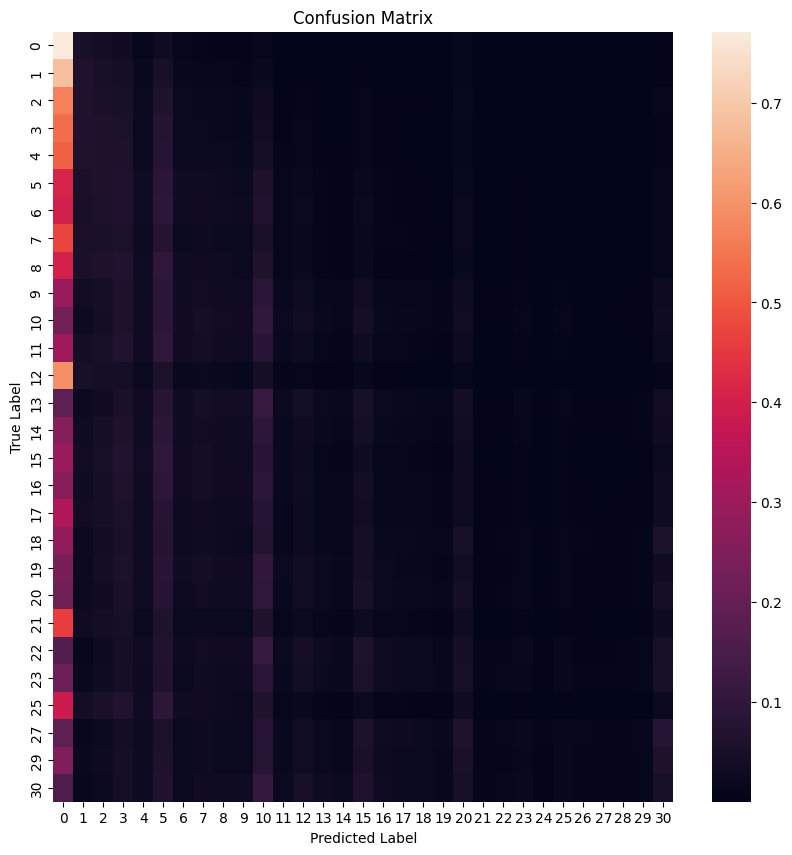

In [82]:
dfs = df_pp[df_pp['p_mask'] == 1]

dfs = dfs.groupby(['true', 'target']).agg({'predict_proba': 'mean'}).reset_index()

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(
    dfs.pivot(index='true', columns='target', values='predict_proba'))
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


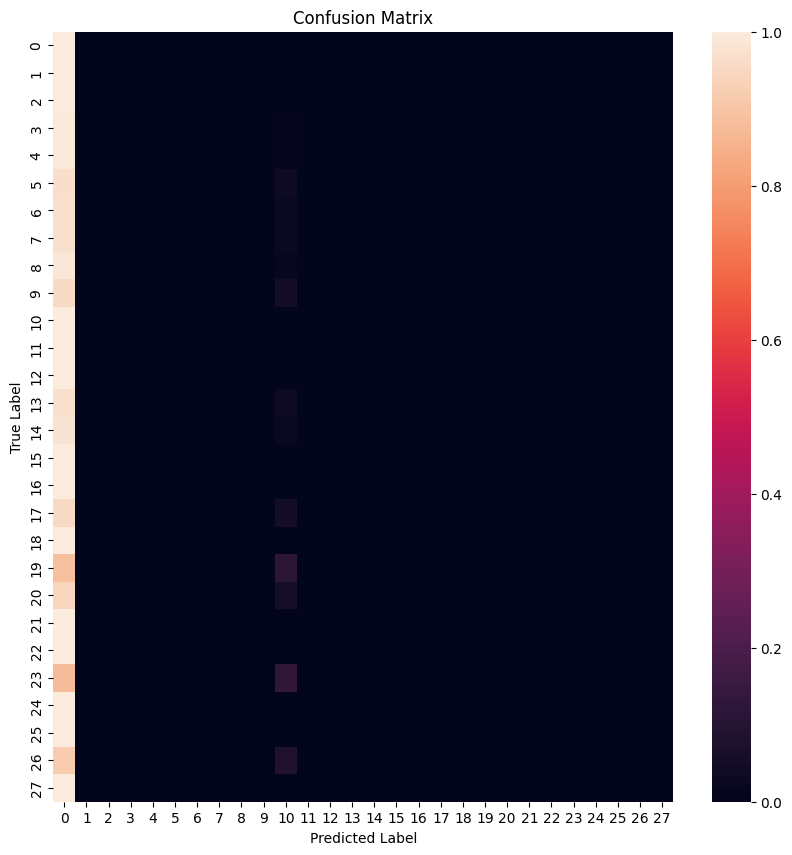

In [83]:
dfs = df[df['p_mask'] == 1]

cm = confusion_matrix(dfs['target'], dfs['prediction'])

# normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [88]:
df[df.batch == 0].head(20)

,batch,seq,prediction,target,mask,c_mask,p_mask
0,0,0,20,10,1,1,0
1,0,1,0,3,1,0,1
2,0,2,10,16,1,1,0
3,0,3,0,0,1,0,1
4,0,4,15,8,1,1,0
5,0,5,0,3,1,0,1
6,0,6,10,18,1,1,0
7,0,7,0,0,1,0,1
8,0,8,15,4,1,1,0
9,0,9,0,6,1,0,1


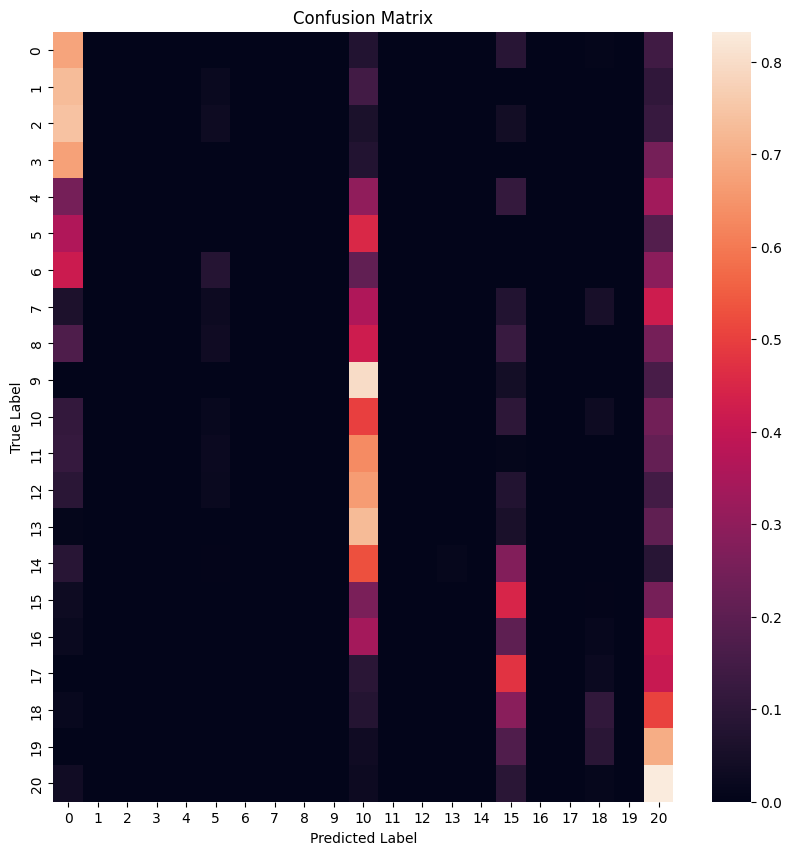

In [84]:
dfs = df[df['c_mask'] == 1]

cm = confusion_matrix(dfs['target'], dfs['prediction'])

# normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()